## New data augmentation techniques: mixup, ricap and cutmix

As you may know, Jeremy claims in his course that data augmentation is perhaps the most important regularization technique when training a model for Computer Vision, second only to getting more data samples (which is often costly or just impossible).

There are a large number of “classical” transforms, most of them already available in fastai (flip, rotate, zoom, cutout, etc). All these transformations have something in common: they are single-image transforms. This means we just use one image to generate a new image. They are used to increase our dataset size by generating new, realistic images.

However, during the last couple of years, new image transformations that blend 2 or more images to create a new image have been released. In this notebook we'll briefly review some of these methods. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

I've created some code we need to import to be able to use these new data augmentations with the fastai library. Hopefully, one day they will be part of the fastai library and won't need to do this.

If you want to be able to use this code, you only need to place the self-contained nb_new_data_augmentation.py script in an accessible folder (like /exp in my case) and import everything.

In [3]:
from exp.nb_new_data_augmentation import *

In [4]:
size=128
bs = 256
path = untar_data(URLs.IMAGENETTE_160); path

PosixPath('/home/oguiza/.fastai/data/imagenette-160')

In this case I'm creating a databunch without any transforms (other than size) so that it's easier to visualize the real impact of each transformation.
This is for demo purposes only. When you use the new data augmentations, you'll be able to decide whether you want to use them jointly with single-image transforms, or just on their own.

## Single-image transforms

These are some of the transforms we are all familiar with. All of them are applied to each individual image. I've selected many of them (some may not make sense) for demo purposes. 

With single-image transforms, we try to increase the amount of available images, and usually select the ones that look more natural to us (those that could be real images). We would usually avoid some flips or excessive rotation. 

With .show_single_img_tfms() you can actually visualize the impact of the selected transforms on a single image so that you can decide if the selected tfms work as you expect.

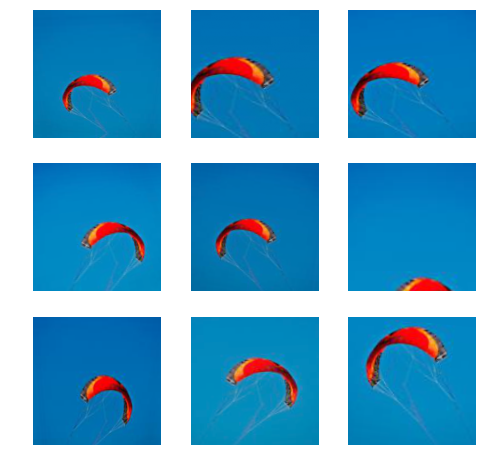

In [5]:
# single-image transforms
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms, size=size) # <-- single-image transforms
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))
learn = Learner(data, models.resnet34()).show_single_img_tfms()

### Cutout (DeVries, 2017)

This is a single-image transformation, but it's very close to some of the newer multi-image ones, since it randomly selects an area that is removed. 

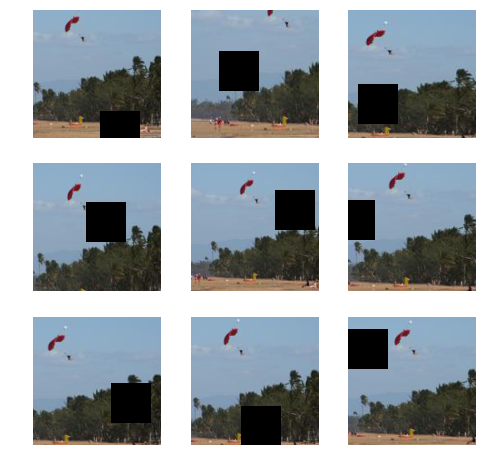

In [6]:
learn.data.train_ds.tfms = [cutout()]
learn.show_single_img_tfms();

## New data transforms: multi-image transforms

There are at least a couple of things multi-image data transforms have in common: 

- they combine 2 or more images to create a new synthetic image
- unlike previous techniques like cutout, the entire image provides informative pixels. 

In this case I'm creating a databunch without any transforms (other than size) so that it's easier to visualize the real impact of each transformation.

This is for demo purposes only. When you use the new data augmentations, you'll be able to decide whether you want to use them jointly with single-image transforms, or just on their own.

In [7]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size) # <-- no transforms 
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

I've created a new function (show_multi_img_tfms) that you can use to easily visualize images created by a callback.

As you'll see, new data augmentation images are sometimes not realistic to us, but they are helpful to improve performance in vision tasks.

### Mixup (Zhang, 2018)

https://arxiv.org/abs/1710.09412

Mixup blends two images drawn at random from our training data. A weight λ (between .5-1) is assigned to the first sample, and 1-λ to the second one. 
Despite its simplicity, mixup allows a new state-of-the-art performance in the CIFAR-10, CIFAR- 100, and ImageNet-2012 image classification datasets.

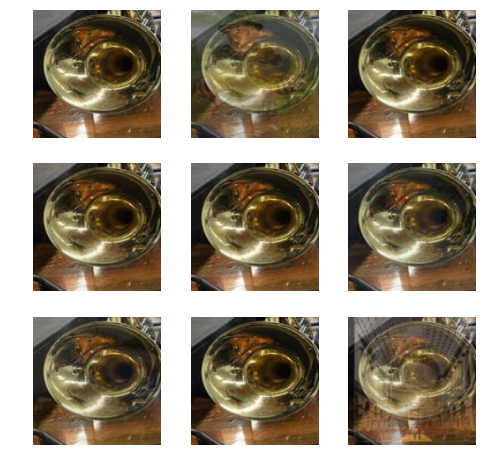

In [8]:
learn = Learner(data, models.resnet34()).mixup()
learn.show_multi_img_tfms();

Isn't it weird that this increases performance??

### Ricap (Takahashi, 2018)

RICAP (Random Image Cropping and Patching) crops four training images and patches them to construct a new training image; it selects images and determines the cropping sizes randomly, where the size of the final image is identical to that of the original image.

RICAP achieves a new state-of-the-art test error of 2.19% on CIFAR-10. We also confirmed that deep CNNs with RICAP achieve better results on classification tasks using CIFAR-100 and ImageNet and an image-caption retrieval task using Microsoft COCO.

It's applied in the following way:
- a pixel coordinate in the image is randomly selected. That creates 4 areas within an image.
- 4 regions from different images are cropped and patched to create a new image. 

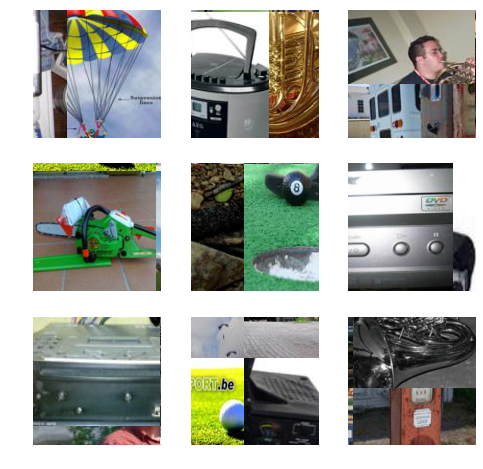

In [9]:
learn = Learner(data, models.resnet34()).ricap().show_multi_img_tfms()

### Cutmix (Yun, 2019)

https://arxiv.org/abs/1905.04899

Cutmix is similar to Cutout, as a single patch is cut and pasted into a different training image.

CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly- supervised localization task.


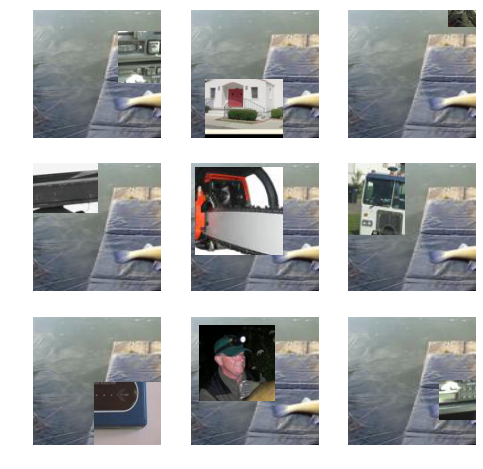

In [10]:
learn = Learner(data, models.resnet34()).cutmix().show_multi_img_tfms()

## How to train using data augmentation?

It's super easy! The only thing you need to do is: 

1. First you will create your ImageDataBunch as you would normally do.
You'll need to decide if you want to apply single-image transformations when you create the databunch. If you decide to use it, just add:

In [11]:
# single-image transforms
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms, size=size) # <-- single-img transforms
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

2. The you will create the learner as usual, but you will add to it the selected multi-image transform you have selected (mixup, ricap or cutmix). You can only select one of these new data augmentations at a time.

In [12]:
# multi-image transforms
learn = Learner(data, models.resnet34()).cutmix()

That's it!!. 
We can now visualize our images just to check everything's working well.

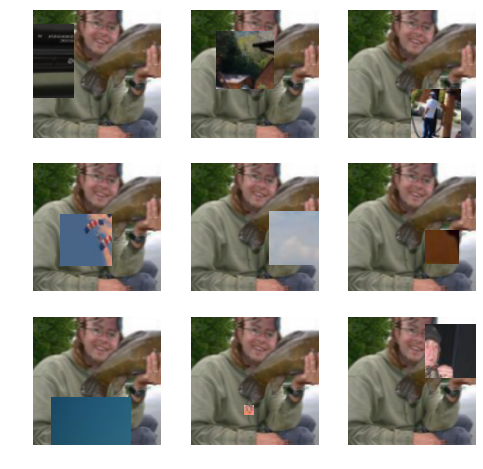

In [13]:
learn.show_multi_img_tfms();

You can also do both in a single step

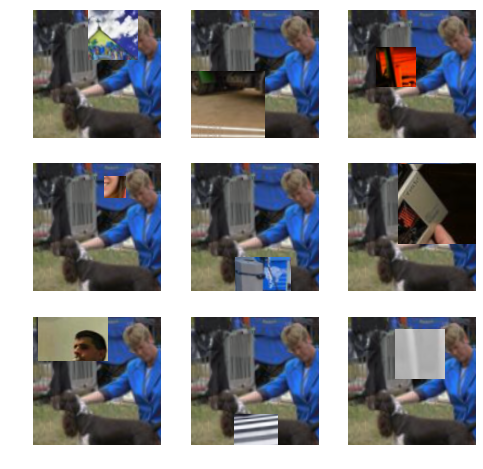

In [14]:
learn = Learner(data, models.resnet34(), metrics=error_rate).cutmix().show_multi_img_tfms()

In [15]:
#learn.fit_one_cycle(5)